In [1]:
import os
import random
from platform import architecture

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torchvision.transforms.functional import to_pil_image
from sklearn.model_selection import KFold
from collections import defaultdict
from optuna import trial

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import optuna
import wandb
# Project utilities
import utils
from train import train_model_with_hyperparams
import matplotlib.pyplot as plt
import tqdm
VGG19 = 'VGG19'
ALEXNET = 'AlexNet'

# Set seed
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

np.random.seed(SEED)
random.seed(SEED)
# torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms = True

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check if you're working locally or not
if not (os.path.exists(utils.CSV_PATH) and os.path.exists(utils.OPTIMIZED_DIR)):
    print(f"[!] You are NOT on the project's directory [!]\n"
          f"Please run the following command (in either CMD or anaconda prompt): \n"
          f"jupyter notebook --notebook-dir PROJECT_DIR\n"
          r"Where PROJECT_DIR is the project's directory in your computer e.g: C:\Users\amitr5\PycharmProjects\deep_van_gogh")

[!] You are NOT on the project's directory [!]
Please run the following command (in either CMD or anaconda prompt): 
jupyter notebook --notebook-dir PROJECT_DIR
Where PROJECT_DIR is the project's directory in your computer e.g: C:\Users\amitr5\PycharmProjects\deep_van_gogh


### Loading our data
We will load the optimized datasets from our custom dataset object


In [ ]:
class NumPyDataset(Dataset):
    def __init__(self, file_path):
        data = np.load(file_path)
        self.images = data["images"]
        self.labels = data["labels"]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

dataset = NumPyDataset(os.path.join(utils.OPTIMIZED_DIR, 'dataset.npz'))

You can find the optimized dataset files <a href="https://drive.google.com/drive/folders/1TBlNcRsRHJ7_rxh_h7_yn_-Ak66Uj_mp?usp=sharing">HERE</a><br/>
Loading the train and test datasets:

In [ ]:
classes = pd.read_csv(utils.CSV_PATH)
train_indices, val_indices = train_test_split(classes[classes['subset'] == 'train'].index.tolist(), test_size=0.2, random_state=SEED)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, classes[classes['subset'] == 'test'].index.tolist())

### Data Augmentation

In [ ]:
# torch.manual_seed(SEED)
# n_times = 25
# dropout_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     *([transforms.RandomErasing(p=0.5, scale=(0.01, 0.01), ratio=(1, 1))]*n_times),
#     transforms.Grayscale(num_output_channels=3),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.224, 0.225])
# ])
# dropout_dataset = Subset(preprocessing.ImageFolderForBinaryClassification(root=ROOT, transform=dropout_transform, target='is_van_gogh'), train_indices)
# augmented_train_dataset = ConcatDataset([dropout_dataset, train_dataset])
# augmented_train_dataset = train_dataset
# train_loader = DataLoader(augmented_train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=8)
# val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)

# Fine tuning VGG19

In [ ]:
class FinedTunedModel(nn.Module):
    def __init__(self, base_model, architecture:str):
        super(FinedTunedModel, self).__init__()
        self._architecture = architecture  # Save the base model architecture
        base_children_list = list(base_model.children())
        self.features_extractor = nn.Sequential(*base_children_list[:-1]).to(device)
        for param in self.features_extractor.parameters():
            param.requires_grad = False

        # Modify the classifier to fit to our problem (2 classes)
        self.classifier = nn.Sequential(*base_children_list[-1])
        self.classifier[-1] = nn.Linear(4096, 2).to(device)  # Replaces the final layer of the base model's classifier with a new fully connected layer

    def forward(self, x):
        base_model_output = self.features_extractor(x)
        return self.classifier(torch.flatten(base_model_output, start_dim=1))
    @property
    def architecture(self):
        return self._architecture



In [3]:
vgg19 = models.vgg19(weights=models.VGG19_Weights.DEFAULT).to(device) # Load pre-trained VGG19 model
vgg_model = FinedTunedModel(vgg19, VGG19).to(device)
vgg_model

NameError: name 'FinedTunedModel' is not defined

In [ ]:
# Optuna for our vgg model with the default config
study = optuna.create_study(study_name=VGG19, direction='minimize')
study.optimize(lambda trial: objective(trial, vgg_model, config={}), n_trials=3)

In [ ]:
# Optuna objective function
def objective(trial, model, config: dict) -> float:
    """
    Generic Optuna objective function.
    :param trial: Optuna trial object.
    :param model: The neural network model to train
    :param config: A dictionary with configurable values such as learning rate ranges, batch size ranges, etc.
    :return:  best_val_loss: The best validation loss achieved during training.
    """
    # Hyperparameter suggestions based on config
    learning_rate = trial.suggest_float("learning_rate",
                                        config.get("lr_min", 1e-5),
                                        config.get("lr_max", 1e-3),
                                        log=True)
    weight_decay = trial.suggest_float("weight_decay",
                                       config.get("wd_min", 1e-6),
                                       config.get("wd_max", 1e-4),
                                       log=True)
    batch_size = trial.suggest_int("batch_size",
                                   config.get("batch_size_min", 32),
                                   config.get("batch_size_max", 128),
                                   step=config.get("batch_size_step", 16))
    patience = config.get("patience", 10)
    epochs = config.get("epochs", 5)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Load the train DataLoader with the chosen batch_size
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Load the val DataLoader with the chosen batch_size

    # Define optimizer and loss function
    criterion = config.get("criterion", nn.CrossEntropyLoss()) # Classification.
    optimizer_class = config.get("optimizer_class", optim.Adam)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Initialize Weights & Biases - the values in the config are the properties of each trial.
    architecture = getattr(model, "architecture", model.__class__.__name__)
    wandb.init(project="deep_van_gogh",
               config={
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "patience": patience,
        "batch_size": batch_size,
        "epochs": epochs,
        "architecture": architecture,
        "dataset": config.get("dataset_name", "Post_Impressionism")
    },
    name=f"{architecture}_trial_{trial.number}") # The name that will be saved in the W&B platform

    # Train the model and get the best validation loss
    best_val_loss = train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion,
                                                 epochs=epochs, patience=patience, device=device, trial=trial,
                                                 architecture=architecture)

    # Finish the Weights & Biases run
    wandb.finish()

    # Return best validation loss as the objective to minimize
    return best_val_loss

# TODO:
# make an objective with best accuracy


## Cross-Validation

In [ ]:
def cross_validation(dataset:Dataset, **models_dict):
    # Initialize KFold
    k_folds = 5
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Track performance for each model
    results = defaultdict(list)

    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
            print(f"\tFold {fold + 1}")
            # Subset the dataset for this fold
            train_subset = Subset(dataset, train_ids)
            val_subset = Subset(dataset, val_ids)

            # Create data loaders
            train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

            for model_name, model_dict in models_dict.items():
                print(f"Training :{model_name}")
                # Load the entire model
                base_model = vgg19 if model_dict["architecture"] == VGG19 else alexnet
                model = FinedTunedModel(base_model.to(device), model_dict["architecture"]).to(device)

                # Define loss function and optimizer
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), **model_dict['param_groups'])



                # Train the model (implement your training loop here)
                best_val_loss = train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion,
                                                             epochs=3, patience=3, device=device, trial=None,
                                                             architecture=None)
                 # Append the results for this fold
                results[model_name].append(best_val_loss)


    # Print final results
    for model_name, model_results in results.items():
         # After all folds, calculate the average fold performance
        mean_perf = sum(results[model_name]) / len(results[model_name])
        print(f"Average Performance for {model_name}: {mean_perf}")

        print(f"{model_name} - Cross-Validation Results: {model_results}")
        print(f"{model_name} - Mean Performance: {sum(model_results) / len(model_results)}")

In [ ]:
vgg_path = os.path.join(utils.MODELS_DIR, VGG19)

def get_hyperparameters(path):
    param_groups = torch.load(path, weights_only=True)['optimizer_state_dict']['param_groups'][0]
    return {'lr':param_groups['lr'], 'weight_decay':param_groups['weight_decay']}


model1_param_groups = get_hyperparameters(f"{vgg_path}/best_model_trial_0.pt") # Load hyperparameters
model1_dict = {
    'architecture': VGG19,
    'param_groups': model1_param_groups
}


model2_param_groups =  get_hyperparameters(f"{vgg_path}/best_model_trial_1.pt") # Load hyperparameters
model2_dict = {
    'architecture': VGG19,
    'param_groups': model2_param_groups
}


cross_validation(train_dataset, vgg_model1=model1_dict, vgg_model2=model2_dict)


# Fine tuning AlexNet

In [4]:
# Load the AlexNet model 
alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT).to(device)
alexnet_model = FinedTunedModel(alexnet, ALEXNET).to(device)
alexnet_model

NameError: name 'FinedTunedModel' is not defined

In [ ]:
study = optuna.create_study(study_name=f'{ALEXNET}', direction='minimize')
study.optimize(lambda trial: objective(trial, alexnet_model, config={}), n_trials=3)

analysing results

# Style transfer function

In [5]:
from PIL import Image
#define a function to load an image and pre-process it
def load_image(img_path, shape=(224,224)):
    image = Image.open(img_path).convert('RGB')
    # Define transformation to resize, normalize, and convert to tensor
    in_transform = transforms.Compose([
        transforms.Resize(shape),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    # Apply transformations, remove alpha channel, and add batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image.to(device)
#define a function to extract features from the network
def get_features(image, model, layers):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Deprocess the image by reversing the normalization
def deprocess(tensor):
    tensor = tensor.cpu().clone().detach()
    tensor = tensor.squeeze(0)
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    tensor = torch.clamp(tensor, 0, 1)
    return to_pil_image(tensor)

In [ ]:
def style_transfer(model, style_img_path, content_img_path, content_weight=1, style_weight=1e3, num_steps=5001, model_name='vgg19_pretrained'):
    model = model.features #Gives us access to the layers of features

    layers = {
         '0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1',
         '21': 'conv4_2'
    }

    style_weights = {
        'conv1_1': 0.5, 'conv2_1': 0.5, 'conv3_1': 0.5, 'conv4_1': 0.3
    }

    content_layer = 'conv4_2'
    # Prepare model for evaluation, disabling gradient computation
    model.to(device).eval()
    for param in model.parameters():
         param.requires_grad_(False)
    # Load and preprocess the content and style images
    content = load_image(content_img_path).to(device)
    style = load_image(style_img_path).to(device)
    # Extract features from content and style images
    content_features = get_features(content, model, layers)
    style_features = get_features(style, model, layers)
    target = content.clone().requires_grad_(True).to(device)

    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    optimizer = optim.Adam([target], lr=0.003)

    # Initialize list to track losses
    losses = []
    # Style transfer loop
    for ii in tqdm.tqdm(range(1, num_steps + 1), desc="Style Transfer Progress"):
        # Extract features from target image
        target_features = get_features(target, model, layers)

        # Compute content loss
        content_loss = torch.mean((target_features[content_layer] - content_features[content_layer])**2)

        # Compute style loss by comparing Gram matrices for each layer
        style_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape
            style_gram = style_grams[layer]
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            style_loss += layer_style_loss / (d * h * w)
        # Calculate total loss and update target image
        total_loss = content_weight * content_loss + style_weight * style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        # Track the loss
        if ii % 1000 == 0:
            losses.append(total_loss.item())
            print(f"Step {ii}, Total loss: {total_loss.item()}")

    # Plot the loss
    #plt.plot(range(0, len(losses) * 100, 100), losses)
    #plt.xlabel('Step')
    #plt.ylabel('Total Loss')
    #plt.title('Loss during Style Transfer')
    #plt.show()

    return target


In [6]:
def style_transfer2(model, style_img_path, content_img_path, layers, style_weights, content_layer, content_weight=1, style_weight=1e3, num_steps=5001,shape=(224,224)):
    model = model.features  # Gives us access to the layers of features

    # Prepare model for evaluation, disabling gradient computation
    model.to(device).eval()
    for param in model.parameters():
        param.requires_grad_(False)
    # Load and preprocess the content and style images
    content = load_image(content_img_path,shape).to(device)
    style = load_image(style_img_path,shape).to(device)
    # Extract features from content and style images
    content_features = get_features(content, model, layers)
    style_features = get_features(style, model, layers)
    target = content.clone().requires_grad_(True).to(device)

    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
    optimizer = optim.Adam([target], lr=0.003)

    # Initialize list to track losses
    losses = []
    # Style transfer loop
    for ii in tqdm.tqdm(range(1, num_steps + 1), desc="Style Transfer Progress"):
        # Extract features from target image
        target_features = get_features(target, model, layers)

        # Compute content loss
        content_loss = torch.mean((target_features[content_layer] - content_features[content_layer])**2)

        # Compute style loss by comparing Gram matrices for each layer
        style_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape
            style_gram = style_grams[layer]
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            style_loss += layer_style_loss / (d * h * w)
        # Calculate total loss and update target image
        total_loss = content_weight * content_loss + style_weight * style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        # Track the loss
        if ii % 1000 == 0:
            losses.append(total_loss.item())
            print(f"Step {ii}, Total loss: {total_loss.item()}")

    return target

In [49]:
def style_transfer_multi_style(model, style_img_paths, style_weights, content_img_path, layers, style_layer_weights, content_layer, content_weight=1, style_weight=1e3, num_steps=5001, shape=(224,224)):
    model = model.features  # Gives us access to the layers of features

    # Prepare model for evaluation, disabling gradient computation
    model.to(device).eval()
    for param in model.parameters():
        param.requires_grad_(False)

    # Load and preprocess the content image
    content = load_image(content_img_path, shape).to(device)
    content_features = get_features(content, model, layers)

    # Load and preprocess the style images
    style_features_list = []
    for style_img_path in style_img_paths:
        style = load_image(style_img_path, shape).to(device)
        style_features = get_features(style, model, layers)
        style_features_list.append(style_features)

    # Combine style features by weighted averaging
    combined_style_features = {}
    for layer in layers.values():
        combined_style_features[layer] = torch.zeros_like(style_features_list[0][layer])
        for i, style_features in enumerate(style_features_list):
            combined_style_features[layer] += style_weights[i] * style_features[layer]
        combined_style_features[layer] /= sum(style_weights)

    target = content.clone().requires_grad_(True).to(device)
    style_grams = {layer: gram_matrix(combined_style_features[layer]) for layer in combined_style_features}
    optimizer = optim.Adam([target], lr=0.003)

    # Initialize list to track losses
    losses = []
    # Style transfer loop
    for ii in tqdm.tqdm(range(1, num_steps + 1), desc="Style Transfer Progress"):
        # Extract features from target image
        target_features = get_features(target, model, layers)

        # Compute content loss
        content_loss = torch.mean((target_features[content_layer] - content_features[content_layer])**2)

        # Compute style loss by comparing Gram matrices for each layer
        style_loss = 0
        for layer in style_layer_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape
            style_gram = style_grams[layer]
            layer_style_loss = style_layer_weights[layer] * torch.mean((target_gram - style_gram)**2)
            style_loss += layer_style_loss / (d * h * w)

        # Calculate total loss and update target image
        total_loss = content_weight * content_loss + style_weight * style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Track the loss
        if ii % 1000 == 0:
            losses.append(total_loss.item())
            print(f"Step {ii}, Total loss: {total_loss.item()}")

            # Deprocess and display the intermediate result
            intermediate_result = deprocess(target)
            plt.imshow(intermediate_result)
            plt.title(f"Step {ii}")
            plt.axis('off')
            plt.show()

    return target

Style Transfer Progress:  20%|█▉        | 998/5001 [00:12<00:52, 76.33it/s]

Step 1000, Total loss: 1756331.625


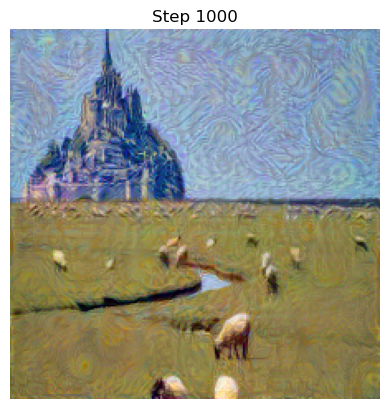

Style Transfer Progress:  40%|███▉      | 1998/5001 [00:26<00:39, 75.53it/s]

Step 2000, Total loss: 1297743.625


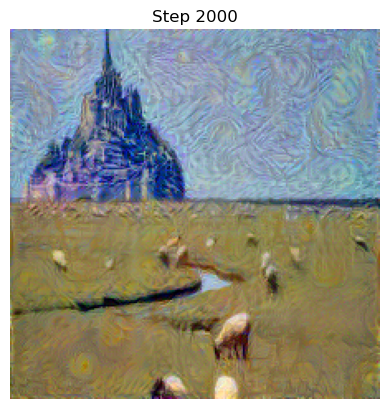

Style Transfer Progress:  60%|█████▉    | 2995/5001 [00:39<00:26, 76.45it/s]

Step 3000, Total loss: 1090708.25


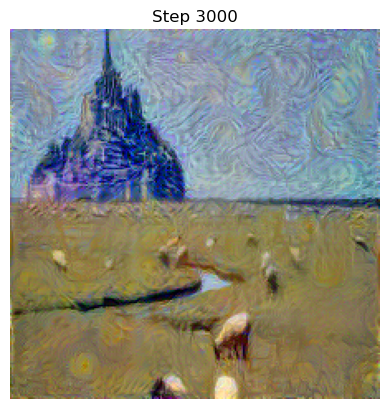

Style Transfer Progress:  80%|███████▉  | 3996/5001 [00:52<00:12, 77.33it/s]

Step 4000, Total loss: 964892.75


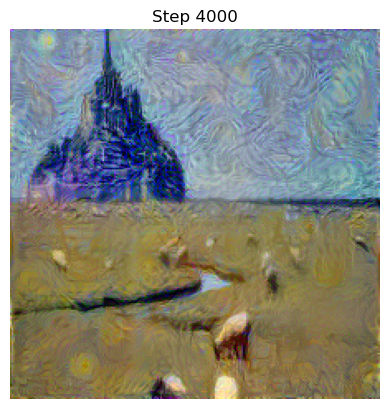

Style Transfer Progress: 100%|█████████▉| 4997/5001 [01:05<00:00, 76.31it/s]

Step 5000, Total loss: 872762.9375


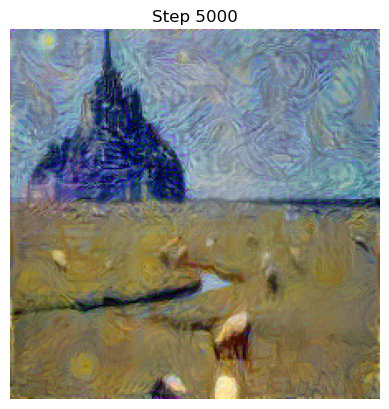

Style Transfer Progress: 100%|██████████| 5001/5001 [01:06<00:00, 75.37it/s]


In [50]:
# Load the style and content images
style_img_paths = ['C:/Users/home/PycharmProjects/deep_van_gogh/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg','C:/Users/home/PycharmProjects/deep_van_gogh/van_Gogh_sunflowers.jpg']
content_img_path = 'C:/Users/home/PycharmProjects/deep_van_gogh/sheep grazing mont saint michel.jpg'
style_weights=(0.7,0.3)
# define the model
model = vgg19
#define style layers and weights
layers = {
         '0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1',
         '21': 'conv4_2'
    }

style_layer_weights = {
        'conv1_1': 0.5, 'conv2_1': 0.5, 'conv3_1': 0.5, 'conv4_1': 0.3
    }

content_layer = 'conv4_2'
# Perform style transfer
stylized_image = style_transfer_multi_style(model, style_img_paths=style_img_paths,style_weights=style_weights, content_img_path=content_img_path,style_weight=1e6, content_weight=0,num_steps=5001,layers=layers,style_layer_weights=style_layer_weights,content_layer=content_layer,shape=(224,224))

# Deprocess and display the image
stylized_image = deprocess(stylized_image)

# Load the original content image to get its resolution
#original_content_image = Image.open(content_img_path)
#original_resolution = original_content_image.size

# Resize the stylized image to the original resolution
#stylized_image = stylized_image.resize(original_resolution, Image.LANCZOS)

# Display the upscaled image
stylized_image.show()
output_path = 'C:/Users/home/PycharmProjects/deep_van_gogh/stylized_image8.png'
stylized_image.save(output_path)